# Imports

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import importlib
import sys
import copy
import os
from sklearn import preprocessing
from scripts.utils import time
import matplotlib.pyplot as plt
import json
import random
import importlib
#- define main directories
MAIN_DIR = 'C:/Users/nourisa/Downloads/testProjs/proteomics_MSC/'
OUTPUT_DIR = os.path.join(MAIN_DIR, 'results')
CALIBRATION_DIR = os.path.join(OUTPUT_DIR, 'calibration')
#- add paths
sys.path.insert(0,MAIN_DIR)
geneRNI_dir = os.path.join(MAIN_DIR,'..','geneRNI')
sys.path.insert(0, geneRNI_dir)
#- local imports
from scripts import utils
from geneRNI import geneRNI, tools, search_param
#- import training data
df_target = pd.read_csv('results/postprocess/DE_data.csv')
#- DE protnames
protnames = list(df_target['Protein'].values)
#- calibration 
param_grid = dict(alpha=np.arange(0,1,.05), min_samples_split=np.arange(2,5,1), min_samples_leaf=np.arange(1,5,1),max_depth=np.arange(10,20,1))

# Process training data
Extract ctr and mg data from the time series

In [ ]:
importlib.reload(utils)
data_ctr = utils.process_data(df_target, study='ctr')
data_mg = utils.process_data(df_target, study='mg')
print('Data shape:', np.array(data_ctr).shape, '(n_samples_time_series*n_genes)')
np.savetxt(os.path.join(OUTPUT_DIR,'data', 'data_ctr.csv'), data_ctr, delimiter=",")
np.savetxt(os.path.join(OUTPUT_DIR,'data', 'data_mg.csv'), data_mg, delimiter=",")

# Hyper params tuning

## Tune parameters

In [ ]:
# tune params using geneRNI: only train set
importlib.reload(search_param)
importlib.reload(tools)
specs = dict(
#     train_flag=True
)
param = dict(estimator_t = 'RF',random_state = 0)
def tune(data, study='ctr', i=0):
    Xs, ys = tools.Data.process_time_series(TS_data=[data], time_points=[time],  gene_names=protnames)
    print(f'----Tuning for {study} iteration {i}-----')
    best_scores, best_params, best_ests, sampled_permts_sorted = \
            search_param.rand_search(Xs, ys, param=param, 
                                     param_grid=param_grid, 
                                     n_jobs=10, n_sample=60, **specs)
    print(f'mean best score {np.mean(best_scores)}')
    return best_scores, best_params
# data, study = data_ctr, 'ctr'
data, study = data_mg, 'mg'
best_scores, best_params = tune(data, study=study) #TODO: this goes into a loop for 100 times

utils.read_write_oo(study, mode='write', best_params=best_params, best_scores=best_scores, OUTPUT_DIR=OUTPUT_DIR)

## plot scores and best params

In [ ]:
#- read the data
best_params_ctr, scores_ctr = utils.read_write_oo('ctr', mode='read', OUTPUT_DIR=OUTPUT_DIR)
best_params_mg, scores_mg = utils.read_write_oo('mg', mode='read', OUTPUT_DIR=OUTPUT_DIR)
#- box plot 
importlib.reload(utils)
#- best score 
fig = utils.plot_bestscores(scores_ctr, scores_mg)
fig.savefig(os.path.join(OUTPUT_DIR,'postprocess','bestscores.png'), dpi=300, transparent=True, facecolor='white')
#- best param
fig = utils.plot_bestparams(best_params_ctr,best_params_mg, priors=param_grid)
fig.savefig(os.path.join(OUTPUT_DIR,'postprocess','bestparams.png'), dpi=300, transparent=True, facecolor='white')

# GRN using geneRNI

In [ ]:
# GRN
import importlib
import json
importlib.reload(tools)
importlib.reload(geneRNI)
importlib.reload(utils)

def GRN(data, study='ctr', i=0):
#     print(f'----GRN for {study}-----')
    Xs, ys = tools.Data.process_time_series(TS_data=[data], time_points=[time],  gene_names=protnames)
    # read the outputs of tunning
    best_params, _ = utils.read_write_oo(study, mode='read', OUTPUT_DIR=OUTPUT_DIR)
    # run the network inference
    param = dict(estimator_t='RF')

    ests, train_scores, links_df, oob_scores, test_scores = \
        geneRNI.network_inference(Xs, ys, gene_names=protnames, 
                                  param=param, param_unique=best_params, 
                                  Xs_test=None, ys_test=None, verbose=False
                                  )
    utils.read_write_links(links=links_df, study=study, mode='write',i=i,OUTPUT_DIR=OUTPUT_DIR)
def run_batch(data, study,istart, iend):
    for i in range(istart, iend):
        GRN(data, study, i)
        print(f'{i} finished')
data_ctr = np.genfromtxt(os.path.join(OUTPUT_DIR,'data', 'data_ctr.csv'),  delimiter=',')
data_mg = np.genfromtxt(os.path.join(OUTPUT_DIR,'data', 'data_mg.csv'),  delimiter=',')

run_batch(data_ctr,'ctr',176, 300) 
# run_batch(data_mg,'mg',389, 500) 

- (check) Filter genes with high test scores

# GRN using Portia

In [ ]:
# portia
importlib.reload(utils)
dir_portia = os.path.join(MAIN_DIR,'..','external/PORTIA-master')
sys.path.insert(0,dir_portia)
import portia as pt
def data_process(data):
    dataset = pt.GeneExpressionDataset()
    exp_id = 1
    for data in data:
        dataset.add(pt.Experiment(exp_id, data))
        exp_id+=1
    return dataset

def GRN(data, study):
    dataset = data_process(data)
    M_bar = pt.run(dataset, method='fast')
    links_df = tools.Links.format(M_bar, protnames)
    
    utils.Links.read_write_links(links=links_df, study=study, mode='write',method='portia',OUTPUT_DIR=OUTPUT_DIR)

#- read the data
data_ctr = np.genfromtxt(os.path.join(OUTPUT_DIR,'data', 'data_ctr.csv'),  delimiter=',')
data_mg = np.genfromtxt(os.path.join(OUTPUT_DIR,'data', 'data_mg.csv'),  delimiter=',')

#- run 
GRN(data_ctr, 'ctr')
GRN(data_mg, 'mg')

# GRN post process

## Pool the links and add scores (only grni) 

In [ ]:
importlib.reload(utils)
method = 'grni'
#- read links extracted during different runs. 
links_ctr = utils.Links.pool_links('ctr', protnames, output_dir=OUTPUT_DIR, n=1000, method=method)
links_sample = utils.Links.pool_links('mg', protnames, output_dir=OUTPUT_DIR, n=1000, method=method)
#- retreive scores
scores_ctr = np.genfromtxt(os.path.join(OUTPUT_DIR,'calibration', 'scores_ctr.csv'),  delimiter=',')
scores_sample = np.genfromtxt(os.path.join(OUTPUT_DIR,'calibration', 'scores_mg.csv'),  delimiter=',')

def add_score_to_links(links, scores, protnames):
    links['FitScore'] = None
    for target, score in zip(protnames, scores):
        links.loc[links['Target'] == target, 'FitScore'] = score
    return links
links_ctr = add_score_to_links(links_ctr, scores_ctr, protnames)
links_sample = add_score_to_links(links_sample, scores_sample, protnames)
#- save
links_ctr.to_pickle(os.path.join(OUTPUT_DIR,'GRN', f'links_ctr_{method}.csv')) # save with pickle because there is a list of items in data
links_sample.to_pickle(os.path.join(OUTPUT_DIR,'GRN', f'links_mg_{method}.csv'))

## ensemble geneRNI and portia

In [21]:
#- retreive the links
def retreive_grni(study):
    links = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN', f'links_{study}_grni.csv'))
    return links
def retreive_portia(study):
    links = pd.read_csv(os.path.join(OUTPUT_DIR,'GRN', f'links_{study}_portia.csv'))
    return links
links_ctr_grni, links_sample_grni = retreive_grni('ctr'), retreive_grni('mg')
links_ctr_portia, links_sample_portia = retreive_portia('ctr'), retreive_portia('mg')
#- normalize
def normalize(links, study):
#     links['Weight'] = links['Weight']/np.std(links['Weight'])
    #- normalize pool of links
    if study=='grni':
        links['WeightPool'] = [row/np.std(links['Weight']) for row in links['WeightPool'].values]
        links['Weight'] = [np.mean(row) for row in links['WeightPool'].values]        
    if study =='portia':
        links['Weight'] = links['Weight']/np.std(links['Weight'])
    #- update the weight
    return links
links_ctr_grni, links_sample_grni = normalize(links_ctr_grni,'grni'), normalize(links_sample_grni,'grni')
links_ctr_portia, links_sample_portia = normalize(links_ctr_portia,'portia'), normalize(links_sample_portia,'portia')

#- combine
def combine(links_1, links_2):
    links = links_1.copy() #you bitch
    keys = ['Weight']
    for key in keys:
        links[key] = (links_1[key] + links_2[key])/2
    return links
links_ctr_ensemble = combine(links_ctr_grni, links_ctr_portia)
links_sample_ensemble = combine(links_sample_grni, links_sample_portia)
#- save
links_ctr_ensemble.to_pickle(os.path.join(OUTPUT_DIR,'GRN', 'links_ctr_ensemble.csv')) # save with pickle because there is a list of items in data
links_sample_ensemble.to_pickle(os.path.join(OUTPUT_DIR,'GRN', 'links_mg_ensemble.csv'))

## Plot distribution of mean weights

In [ ]:
importlib.reload(utils)
links_combined = [links_ctr_grni, links_sample_grni,
               links_ctr_portia, links_sample_portia, 
               links_ctr_ensemble, links_sample_ensemble]
labels = ['ctr grni','mg grni','ctr portia','mg portia','ctr ensemble','mg ensemble']
utils.Links.plot_mean_weights(links_combined, labels)

## Compare different methods: matching with string

In [26]:
importlib.reload(utils)
#- create random links
def create_random_links(links_target):
    random_links = links_target.copy()
    weightpoolpool = np.array([i for j in links_target['WeightPool'].values.tolist() for i in j])
    weightpoolvector = []
    for i in range(len(links_target)):
        weightpoolvector.append(np.random.choice(weightpoolpool, 1000))
    random_links['WeightPool'] = weightpoolvector
    random_links['Weight']= np.mean(weightpoolvector, axis=1)
    return random_links
links_ctr_random = create_random_links(links_ctr_grni)

links_ctr_grni_short = utils.Links.filter_fitscore(links_ctr_grni)
match_count_grni = utils.Links.compare_network_string_distribution(links_ctr_grni_short, OUTPUT_DIR)

links_ctr_portia_short = utils.Links.filter_toplinks(links_ctr_portia)
match_count_portia = utils.Links.compare_network_string(links_ctr_portia_short.copy(), OUTPUT_DIR)
match_count_portia = [match_count_portia for i in range(1000)]

match_count_ensemble = utils.Links.compare_network_string_distribution(links_ctr_ensemble, OUTPUT_DIR)

match_count_random = utils.Links.compare_network_string_distribution(links_ctr_random, OUTPUT_DIR)

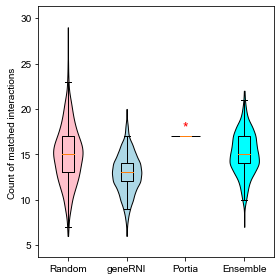

In [27]:
#- sign test, extracted links vs random links
import scipy
import statistics
pvalues = []
s, p = scipy.stats.ttest_ind(match_count_grni, match_count_random)
pvalues.append(p)
s, p = scipy.stats.ttest_ind(match_count_portia, match_count_random)
pvalues.append(p)
s, p = scipy.stats.ttest_ind(match_count_ensemble, match_count_random)
pvalues.append(p)
#- plot violin for match scores
importlib.reload(utils)
fig=utils.Links.plot_match_counts([match_count_random, match_count_grni, match_count_portia,match_count_ensemble], labels=['Random', 'geneRNI','Portia','Ensemble'], pvalues=pvalues)
fig.savefig(os.path.join(OUTPUT_DIR, 'postprocess/match_count.png'), dpi=300, transparent=True)

## Filter

In [31]:
importlib.reload(utils)
def filter(links, study, method, select_scores=False):
    links_short = utils.Links.filter_toplinks(links)
    links_short.to_pickle(os.path.join(OUTPUT_DIR,'GRN',f'links_short_{study}_{method}.csv'))
    return links_short
#-- portia 
method = 'portia'
filter(links_ctr_portia, 'ctr', 'portia')
filter(links_sample_portia, 'mg', 'portia')
#-- grni 
method = 'grni'
filter(links_ctr_grni, 'ctr', 'grni', select_scores=True)
filter(links_sample_grni, 'mg', 'grni', select_scores=True)

number of links after toplinks 281
number of links after toplinks 281
number of links after toplinks 281
number of links after toplinks 281


,Regulator,Target,Weight,WeightPool,FitScore
0,O15143,P12956,2.030379,"[0.8941218550395663, 0.8941218550395663, 1.678...",0.255402
1,O15143,P26447,1.443617,"[1.208207318289671, 1.208207318289671, 0.82262...",0.066704
2,O15143,P30085,4.551795,"[5.772337893006231, 5.772337893006231, 5.98033...",0.461833
3,O15143,Q02818,1.311369,"[0.792154716084908, 0.792154716084908, 1.06572...",-0.392936
4,O15143,Q14011,1.517187,"[1.020773850610694, 1.020773850610694, 1.32244...",-0.331473
...,...,...,...,...,...
276,Q9Y3D6,P38606,2.592249,"[2.3905696313600537, 2.3905696313600537, 2.697...",0.643672
277,Q9Y3D6,P62854,1.819467,"[2.0661223406905833, 2.0661223406905833, 0.842...",0.641272
278,Q9Y3D6,Q07065,1.643163,"[2.608630037618318, 2.608630037618318, 1.50652...",-0.382761
279,Q9Y3D6,Q13162,2.938389,"[2.6022197451302693, 2.6022197451302693, 2.651...",0.72844


## Plot shortlisted weights

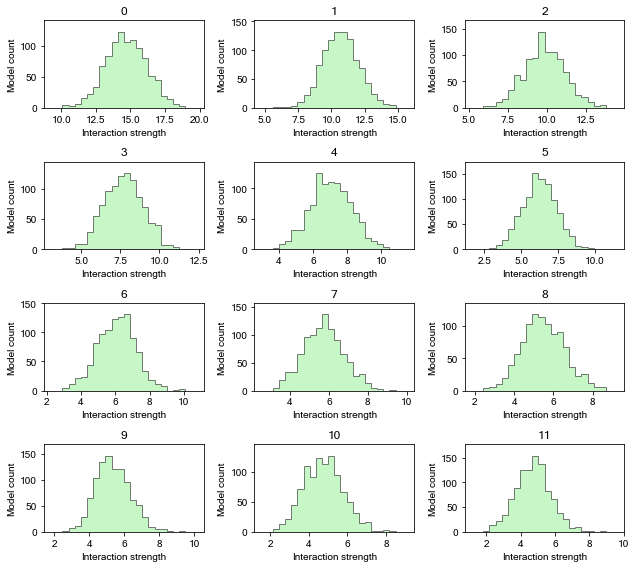

In [32]:
def plot_weight(links, dist_key='WeightPool'):
    links_s = links.sort_values('Weight', ascending=False).reset_index(drop=True)
    
    top_n = 12
    nrows = 4
    ncols = 3
    fig, axes = plt.subplots(nrows, ncols, tight_layout=True, figsize=(ncols*3, nrows*2))
    for idx in range(top_n):
        i = int(idx/(nrows-1))
        j = idx%ncols
        ax = axes[i][j]
        ax.hist(links_s[dist_key][idx], bins=20, alpha=0.5,
                        histtype='stepfilled', #'bar', 'barstacked', 'step', 'stepfilled'
                        color='lightgreen',
                        ec='black',
                        rwidth=.9
                       )
        ax.set_xlabel('Interaction strength')
        ax.set_ylabel('Model count')
#         title = links['Regulator'][idx]+'-->'+links['Target'][idx]
        title= idx
        ax.set_title(title)
        ax.set_ymargin(.15)
        ax.set_xmargin(.15)
def plot_pvalue(x):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(3, 2))
    
    ax.hist(x, bins=20, alpha=0.5,
                    histtype='barstacked', #'bar', 'barstacked', 'step', 'stepfilled'
                    ec='black',
                    rwidth=.9
                   )
    ax.set_xlabel('Interaction strength')
    ax.set_ylabel('Model count')
links_short_ctr_grni = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN','links_short_ctr_grni.csv'))

links_target = links_short_ctr_grni
plot_weight(links_target, dist_key='WeightPool')
# print(links_short_ctr_ensemble)

## create edges and nodes

In [33]:
links_short_ctr_portia = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN','links_short_ctr_portia.csv'))
links_short_sample_portia = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN','links_short_mg_portia.csv'))

def process_nodes_edges(study, links, scores=None):
    #- create nodes and edges
    nodes, edges = utils.convert_links_to_nodes_edges(links, protnames, scores)
    #- output edges and nodes   
    utils.read_write_nodes_edges(nodes=nodes, edges=edges, study=study, mode='write', OUTPUT_DIR=OUTPUT_DIR)
process_nodes_edges('ctr', links_short_ctr_portia)
process_nodes_edges('mg', links_short_sample_portia)

successfully wrote nodes and edges to  C:/Users/nourisa/Downloads/testProjs/proteomics_MSC/results\GRN
successfully wrote nodes and edges to  C:/Users/nourisa/Downloads/testProjs/proteomics_MSC/results\GRN


# Vester's sensitivity analysis. 
- AS: active sum. Sum along rows of the influence matrix and it indicates how much does a variable influence all the others.
- PS: passive sum. Its is the sum along columns of the influence matrix and it indicates how sensitive a variable is, how does it react to the influence of others
- Q: AS/PS -> how dominant
- P: AS.PS -> how participative a variable is
- Active: +Q
- Passive: -Q, -P
- Critical: +Q, +P
- Buffering: -Q, -P

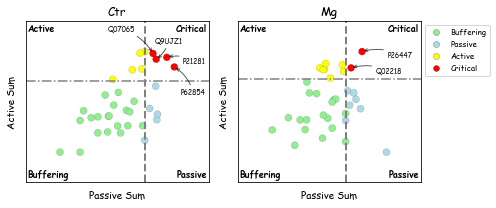

In [81]:
importlib.reload(utils)
#- retreive data: short links
method = 'portia'
links_ctr = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN',f'links_short_ctr_{method}.csv'))
links_sample = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN',f'links_short_mg_{method}.csv'))

oo_vsa_ctr = utils.VSA.analyse(links_ctr, protnames)
oo_vsa_sample = utils.VSA.analyse(links_sample, protnames)
#- plot 1: seperate windows for ctr and sample
utils.VSA.plot_ctr_vs_sample(oo_vsa_ctr,oo_vsa_sample, protnames, OUTPUT_DIR=OUTPUT_DIR)

## Role change & plot 

P21281
P26447
P62854
Q02218
Q07065
Q9UJZ1


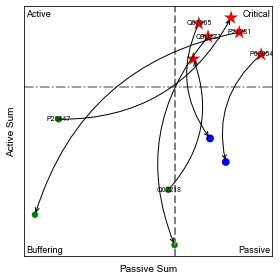

In [8]:
#- read the data
importlib.reload(utils)
# - plot 2: change in the roles 
df_role_change = utils.VSA.role_change(oo_vsa_ctr, oo_vsa_sample, target_roles=[3])
df_role_change.to_csv(os.path.join(OUTPUT_DIR,'VSA','df_role_change.csv'),index=False)
utils.VSA.plot_role_change(df_role_change, OUTPUT_DIR=OUTPUT_DIR)

# Sensitivity analysis

## multiplicative gaussian noise

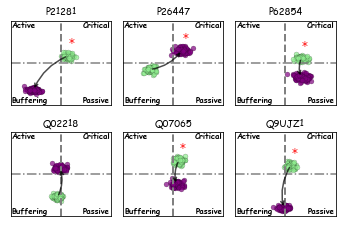

In [125]:
importlib.reload(utils)
#- retreive data
df_role_change = pd.read_csv(os.path.join(OUTPUT_DIR,'VSA','df_role_change.csv'),index_col=False)
target_prots = df_role_change['Entry'].values.tolist() 

method = 'portia'
links_ctr = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN',f'links_short_ctr_{method}.csv'))
links_sample = pd.read_pickle(os.path.join(OUTPUT_DIR,'GRN',f'links_short_mg_{method}.csv'))
#- multiplicative gaussian noise
# utils.SensitivityAnalysis.multiGaussNoise(links_ctr, links_sample, protnames, target_prots, OUTPUT_DIR)
#- additive gaussian noise
utils.SensitivityAnalysis.addGaussNoise(links_ctr, links_sample, protnames, target_prots, OUTPUT_DIR)

# Visualize protein network 

In [ ]:
importlib.reload(utils)
with open(os.path.join(OUTPUT_DIR, 'postprocess/map_protname_genename.json')) as f:
    map_protname_genename = json.load(f)['map']
# preferred_names = [map_protname_genename[protname] for protname in protnames]
preferred_names =protnames
def visualize(study):
    #- retreive nodes and edges
    nodes, edges = utils.read_write_nodes_edges(study=study, mode='read', OUTPUT_DIR=OUTPUT_DIR)
    utils.visualize_network(nodes, edges, 'ctr', protnames, preferred_names, OUTPUT_DIR)
visualize('ctr')

In [ ]:
import igraph
igraph.drawing.shapes.DiamondDrawer()